# Have the Stars Realigned? A Post-Exposé Analysis on Fandango’s Inflated Movie Ratings

### Project Background and Goal

In October 2015, a journalist from FiveThirtyEight published an [article](https://fivethirtyeight.com/features/fandango-movies-ratings) presenting strong evidence to suggest [Fandango's](https://www.fandango.com) movie rating system was **biased** and **dishonest**:

>* The true movie rating was almost always rounded up to the nearest half star (e.g., a 4.1 would be displayed as a 4.5 star rating).
>
>* In 8% of the cases analysed, half star ratings were shown to be rounded up to the nearest whole star (e.g., a 4.5 may be rounded up to a 5 star rating).
>
>* One case showed a highly unexpected 5 star rating, inflated from a rating value of 4 which was recorded in the HTML for the page.

Following the exposé, the official response claimed that biased rounding was a result of a bug in their system rather than being intentional. They promised to fix the errors as soon as possible. We can presume this happened, but it is no longer clear since the numerical rating values are no longer displayed in the HTML for the webpage.

**Aim:**

>This project sets out to determine if any meaningful change in the ratings have occurred post-exposé by analysing movie ratings scraped from Fandango over the years 2016-2017 (around 1-2 years following the journalist's article). 

---

## About the Datasets

The original data analysis conducted to reveal the dishonesty in displayed ratings was made publically available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). 

The `fandango_scores_comparison.csv` file contains the associated data. This analysis will focus on the following fields from this dataset:

| Column                           | Description                                                                                                               |
|----------------------------------|---------------------------------------------------------------------------------------------------------------------------|
| FILM                             | The film title and release year.                                                                                          |
| Fandango_Stars                   | The number of stars displayed for the film on the Fandango webpage.                                                       |
| Fandango_Ratingvalue             | The Fandango rating value as pulled from the HTML of the website. This is the **actual** average score the movie obtained.|
| Fandango_votes                   | The number of user votes the film had on Fandango.                                                                        |
| Fandango_Difference              | The difference between the presented Fandango_Stars and the actual Fandango_Ratingvalue.                                  |

 ---
 Another individual collated movie ratings over the years 2016-2017, using Fandango as one of the data sources. This dataset is also publically available on [GitHub](https://github.com/mircealex/Movie_ratings_2016_17).

 The `movie_ratings_16_17.csv` file contains the data associated with this dataset. For the following report, the following fields will be utilised:

 | Column                           | Description                                                                                                               |
 |----------------------------------|---------------------------------------------------------------------------------------------------------------------------|
 | movie                            | The title of the film.                                                                                                    |
 | year                             | The release year of the film.                                                                                             |
 | fandango                         | The Fandango rating of the film (user score).                                                                             |

## Preparing the Workbook

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100 # prevents truncated outputs by raising maximum number of rendered columns

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde # required for producing kernel density plots

%matplotlib inline
sns.set_theme()

## Reading in and Preparing the Datasets

In [2]:
before = pd.read_csv("fandango_score_comparison.csv") # the original dataset used to expose the dishonesty

after = pd.read_csv("movie_ratings_16_17.csv") # the post-exposé dataset to compare with in this follow-up analysis

before.head(3)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [3]:
after.head(3)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


We collect the fields of interest from both datasets and perform basic cleaning tasks including: 

* Standardizing column names 

* Checking for null values 

* Adding new columns 

* Combining the datasets

*Note,* copies are created to avoid the pandas `SettingWithCopy` warnings.

In [4]:
fandango_before = before[["FILM", "Fandango_Stars", "Fandango_Ratingvalue", "Fandango_votes", "Fandango_Difference"]].copy() # collect relevant fields from the original dataset

fandango_after = after[["movie", "year", "fandango"]].copy() # collect relevant fields from the post-exposé dataset

fandango_before.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [5]:
fandango_after.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


In [6]:
fandango_before.rename({"FILM": "movie", "Fandango_Stars": "fandango_stars", "Fandango_Ratingvalue": "fandango_rating", "Fandango_votes": "fandango_votes", "Fandango_Difference": "fandango_diff"}, axis=1, inplace=True)

In [7]:
fandango_before.head(3)

,movie,fandango_stars,fandango_rating,fandango_votes,fandango_diff
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [8]:
fandango_before["year"] = fandango_before["movie"].str.extract(r"\((\d+)\)").astype(int) # extract the year from the movie column and save as a new column

fandango_before["movie"] = fandango_before["movie"].str.replace(r"\((\d+)\)", "", regex=True) # remove the year from the movie column

fandango_before["movie"] = fandango_before["movie"].str.strip() # remove leading and trailing whitespace

fandango_before["after_exposé"] = False # create a new column indicating if the record was collected after the exposé

fandango_before = fandango_before[["movie", "year", "fandango_stars", "fandango_rating", "fandango_votes", "fandango_diff", "after_exposé"]] # reorder columns

fandango_before.head(3)

,movie,year,fandango_stars,fandango_rating,fandango_votes,fandango_diff,after_exposé
0,Avengers: Age of Ultron,2015,5.0,4.5,14846,0.5,False
1,Cinderella,2015,5.0,4.5,12640,0.5,False
2,Ant-Man,2015,5.0,4.5,12055,0.5,False


In [9]:
fandango_before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie            146 non-null    object 
 1   year             146 non-null    int64  
 2   fandango_stars   146 non-null    float64
 3   fandango_rating  146 non-null    float64
 4   fandango_votes   146 non-null    int64  
 5   fandango_diff    146 non-null    float64
 6   after_exposé     146 non-null    bool   
dtypes: bool(1), float64(3), int64(2), object(1)
memory usage: 7.1+ KB


In [10]:
fandango_after.rename({"fandango": "fandango_stars"}, axis=1, inplace=True) # standardize column name

fandango_after["after_exposé"] = True # create a new column indicating records were collected after the exposé

fandango_after = fandango_after[["movie", "year", "fandango_stars", "after_exposé"]] # reorder columns

fandango_after.head(3)

,movie,year,fandango_stars,after_exposé
0,10 Cloverfield Lane,2016,3.5,True
1,13 Hours,2016,4.5,True
2,A Cure for Wellness,2016,3.0,True


In [11]:
fandango_after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie           214 non-null    object 
 1   year            214 non-null    int64  
 2   fandango_stars  214 non-null    float64
 3   after_exposé    214 non-null    bool   
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 5.4+ KB


In [12]:
fandango_merged = pd.concat([fandango_before, fandango_after], ignore_index=True) # combine the two datasets

fandango_merged.head()

,movie,year,fandango_stars,fandango_rating,fandango_votes,fandango_diff,after_exposé
0,Avengers: Age of Ultron,2015,5.0,4.5,14846.0,0.5,False
1,Cinderella,2015,5.0,4.5,12640.0,0.5,False
2,Ant-Man,2015,5.0,4.5,12055.0,0.5,False
3,Do You Believe?,2015,5.0,4.5,1793.0,0.5,False
4,Hot Tub Time Machine 2,2015,3.5,3.0,1021.0,0.5,False


In [13]:
fandango_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie            360 non-null    object 
 1   year             360 non-null    int64  
 2   fandango_stars   360 non-null    float64
 3   fandango_rating  146 non-null    float64
 4   fandango_votes   146 non-null    float64
 5   fandango_diff    146 non-null    float64
 6   after_exposé     360 non-null    bool   
dtypes: bool(1), float64(4), int64(1), object(1)
memory usage: 17.4+ KB


In [14]:
fandango_merged.to_csv("before_and_after_exposé.csv", index=False) # save a copy of the combined dataset as a csv

The end goal is to determine whether there is any noticeable change in the Fandango ratings following the 2015 publication of the inaccurate Fandango star rating scores. Our population of interest comprises of **all** Fandango movie ratings stored on the site, regardless of the release year or number of votes received.

As a result, to gauge whether there is a change in the population parameters after the exposé was published, we are interested in sampling the population at two different timepoints - one prior to the article release, and one following the article. 

We have two samples which we have merged into the same `fandango_merged` dataframe (above). To ensure our conclusions are accurate, we need representative samples, otherwise, large sampling errors can arise, leading to unreliable conclusions.

### Original Dataset

From the `README.md` file available in the [GitHub repository](https://github.com/fivethirtyeight/data/blob/master/fandango/README.md) for the initial investigation into the Fandango ratings, we can see the following sampling criteria was used:

* Movies in the chosen for the sample must have at least 30 fan reviews.

* The movie must have had tickets on sale in the year 2015.

The sampling strategy used here is **purposive**, a non-probability sampling technique where the researcher selects individual data points according to specific characteristics. This is appropriate in some research contexts or to answer specific questions. 

This is clearly a non-random strategy since many potential individuals in the overall population had 0 chance of being selected. We therefore cannot be confident that this sample is truly representative of the entire population we aim to describe. It appears less likely to be representative - the sample is highly subject to *temporal trends* (e.g., 2015 movies may have been unexpectedly good or bad with respect to other years).

For our purposes, this sample is not exactly appropriate for the question we are attempting to answer.

---

### Post-exposé Dataset

The second dataset is also subject to these temporal trends. Again, reading the `README.md` file available in the [GitHub repo](https://github.com/mircealex/Movie_ratings_2016_17), the sample criteria are listed as follows:

* The movie must be released in 2016 or later (only data for 2016/2017 was collected).

* The movie must have had a "considerable" number of votes and reviews - it is not specified what the threshold for this criterion is.

Again, a purposive sampling strategy was used by the researcher here, harming the ability of the sample to represent our population of interest. 



## Deviating from the Initial Aim 

Since the samples are not ideal to answer the initial question posed at the beginning of the report, we can either proceed to gather new samples which are more representative of our target population (using randomised sampling strategies), or we can modify our initial question to change the population we are attempting to analyse.

We can proceed with the latter of the two suggestions - it is **considerably** more time-efficient and practical:

> * Instead of determining if there is any change in Fandango's rating system following the journalist's article, we can turn to determine if there is any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. 

This modified end goal should still remain a good proxy for our initial goal, and enable us to use the existing samples.

## Filtering the Samples to Isolate the Relevant Data

Since we have modified our end goal, our population of interest has now changed to "popular" Fandango movie ratings for movies released in 2015/2016. 

The "popular" criteria is not well-defined at this stage, but we can use the original benchmark for a popular movie of *at least 30 fan ratings* being featured for a movie on the Fandango site.

In [15]:
fandango_merged["year"].value_counts().sort_index()

year
2014     17
2015    129
2016    191
2017     23
Name: count, dtype: int64

In [16]:
fandango_2015 = fandango_merged[fandango_merged["year"] == 2015] # filter records for 2015

fandango_2016 = fandango_merged[fandango_merged["year"] == 2016] # filter records for 2016

In [17]:
fandango_2015["year"].value_counts()

year
2015    129
Name: count, dtype: int64

In [18]:
fandango_2016["year"].value_counts()

year
2016    191
Name: count, dtype: int64

## Comparing Distribution Shapes for Fandango Star Ratings for 2015 vs. 2016

In order to assess whether there is any notable change in the star ratings displayed on the Fandango site prior to and after release of the exposé, we can compare the shape of the distributions of ratings for each year.

To do this, we can visualize the distributions using a number of charts. 

A variety of plots are created below:

* Kernel Density Estimate plots (KDEs)

* Strip plots

* Box plots

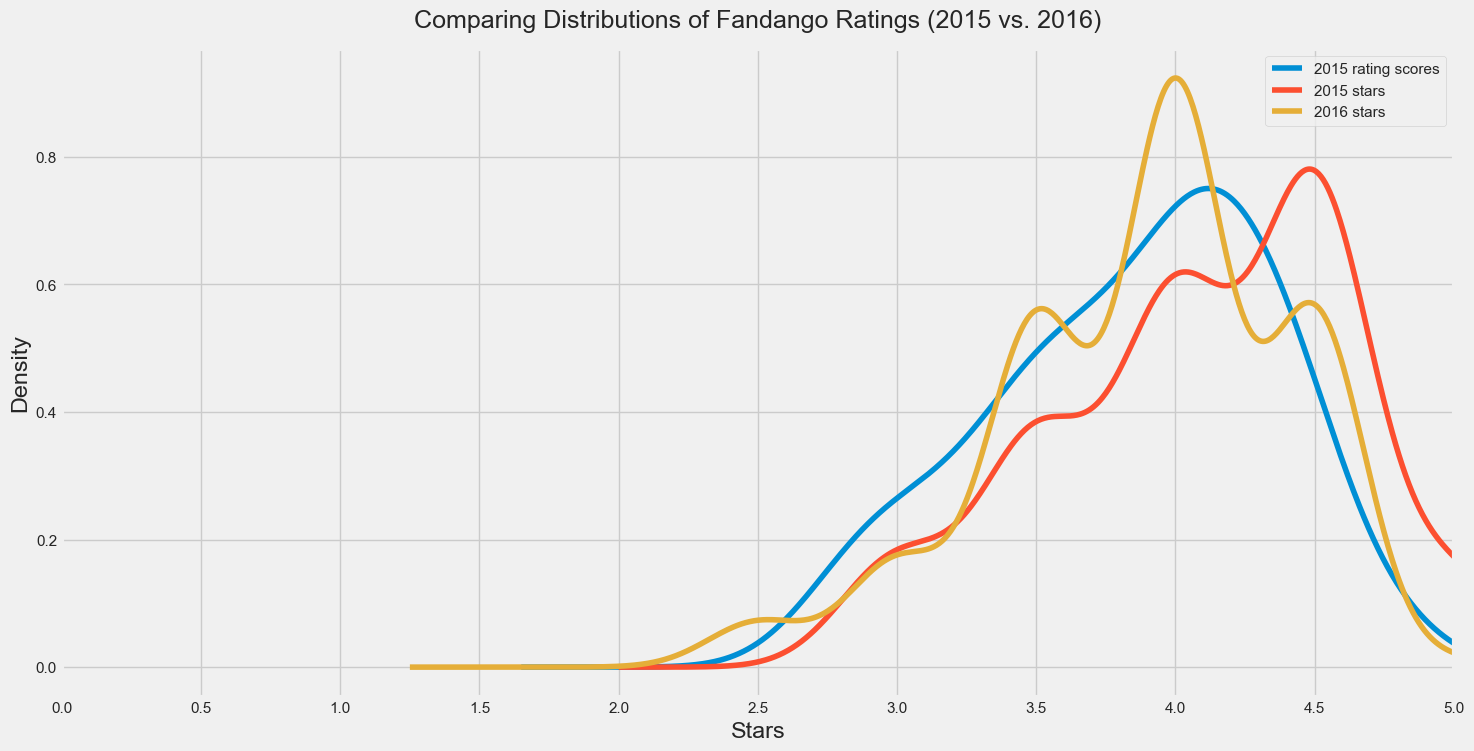

In [89]:
plt.style.use("fivethirtyeight")

fandango_2015["fandango_rating"].plot.kde(label="2015 rating scores", figsize=(16, 8))
fandango_2015["fandango_stars"].plot.kde(label="2015 stars")
fandango_2016["fandango_stars"].plot.kde(label="2016 stars")

plt.title("Comparing Distributions of Fandango Ratings (2015 vs. 2016)", fontsize=18, y=1.02)
plt.xlabel("Stars")
plt.xlim(0, 5)
plt.xticks(np.arange(0, 5.1, 0.5))

plt.ylabel("Density")

plt.legend()

plt.show()

### Remarks

There are three main points of interest in the KDE plot above:

>* Both star rating distributions are strongly left-skewed.
>
>* The 2015 **rating score** distribution is considerably more left-shifted than the 2015 star distribution.
>
>* The 2016 star rating distribution is shifted to the left relative to the 2015 distribution.

The strong left skew of all distributions indicates movie ratings on Fandango are predominantly given **high** fan ratings - there is a significantly higher probability of movies being rated above 3.5 stars than any other possible value in the 0-5 range. 

>The observation that the 2015 rating score distribution is left-shifted relative to the 2015 star distribution corroborates the findings reported in the original exposé: that the true audience ratings were **not** accurately portrayed on the Fandango site.

>Since Fandango also acts as a ticket seller, this appears quite *dubious*. Artificially inflating ratings on the site could easily mislead the public, build hype and serve to encourage a greater number of ticket sales. Further investigation would be necessary to pursue this allegation further. As it goes beyond the main goal of this project, we will not take this any further.

---

With regards to our analysis, there is a clear left-shift in the 2016 popular movie star ratings. The most probable star rating **drops** to 4.0 in 2016, down from approximately 4.5 stars in 2015. This acts as evidence to suggest there is indeed a difference between Fandango's 2015 and 2016 popular movie ratings. 

This does seem to support the official statement which claimed they were working to fix inflated ratings.

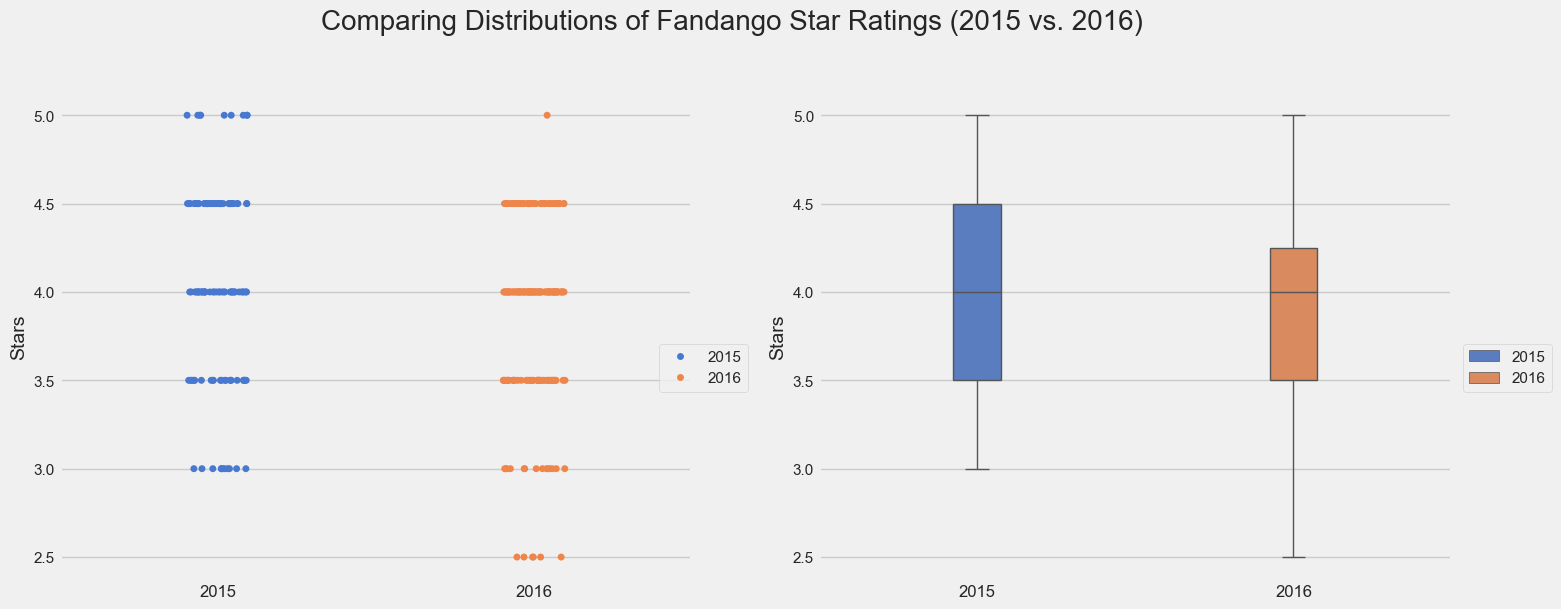

In [91]:
plt.style.use("fivethirtyeight")

palette = sns.color_palette("muted", 2)

plt.figure(figsize=(16, 6))

plt.suptitle("Comparing Distributions of Fandango Star Ratings (2015 vs. 2016)", fontsize=20, y=1.02)

plt.subplot(1,2,1)

sns.stripplot(x="year", y="fandango_stars", hue="year", palette=palette, data=pd.concat([fandango_2015, fandango_2016]), jitter=True)

plt.xticks(fontsize=12)
plt.xlabel("")

plt.ylabel("Stars", fontsize=14)

plt.legend(bbox_to_anchor=(1.1,0.5))

plt.subplot(1,2,2)

sns.boxplot(x="year", y="fandango_stars", hue="year", palette=palette, data=pd.concat([fandango_2015, fandango_2016]), width=0.15)

plt.xticks(fontsize=12)
plt.xlabel("")

plt.ylabel("Stars", fontsize=14)

plt.legend(bbox_to_anchor=(1.17,0.5))

plt.show()


### Remarks on the Strip and Box Plots

The strip and box plots provided above echo the key points highlighted above. 

We can also pick out a clear downwards shift in popular movie ratings moving from 2015 to 2016. The entire distribution seems to shift downwards, with fewer maximum star ratings and a handful of lower 2.5 star ratings appearing in 2016. 

We also observe the interquartile range tightening up moving to 2016 since the spread of ratings in the central 50% of the datapoints becomes smaller. The overall range does increase however, with a number of lower rated movies widening the extrema value separation.

### Frequency Tables

In [104]:
print("2015" + "\n" + "-"*30)
fandango_2015[["fandango_stars"]].value_counts(normalize=True).sort_index(ascending=False) * 100

2015
------------------------------


fandango_stars
5.0                6.976744
4.5               37.984496
4.0               28.682171
3.5               17.829457
3.0                8.527132
Name: proportion, dtype: float64

In [105]:
print("2016" + "\n" + "-"*30)
fandango_2016[["fandango_stars"]].value_counts(normalize=True).sort_index(ascending=False) * 100

2016
------------------------------


fandango_stars
5.0                0.523560
4.5               24.607330
4.0               40.314136
3.5               24.083770
3.0                7.329843
2.5                3.141361
Name: proportion, dtype: float64

### Remarks on the Frequency Tables

>Of the 129 movies in the 2015 sample, nearly 7% had a full 5-star rating. This seems extraordinarily high for movie ratings. A further 38% had ratings around 4.5 stars, which is a large portion of the dataset. The 2015 data is clearly highly left-skewed, even from inspection of the frequency table alone.

>Moving to the 2016 dataset, of the 191 movies in the sample, a huge reduction in the percentage of 5 star movies is observed, dropping to a mere 0.5%. The number of 4.5 star ratings also took a notable hit, dropping to slightly less than 25%. We also observe a small number (~3%) of movies in the sample with star ratings falling to the new low of 2.5 stars. It is still interesting that there are no examples of movies below this, however, it may be explained due to the fact that "popular" movies were selected (hence it is far less likely for any of these movies to have poor ratings).

>One notable observation that the visualizations overlooked is the fact that the percentage of **4-star rated movies actually increased** moving from 2015 to 2016. This could be explained by the large portion of 4.5 star rated movies from 2015. If the presented star ratings were amended following the journalist's article, we should expect a sudden surge in 4-star ratings since many of the 4.5 star rated movies would be correctly rounded down to 4 stars (e.g., a 4.1 rated movie would be amended to display 4 stars and **not** 4.5).

## Summary Statistics to Evaluate the Direction of the Overall Change

In [126]:
from statistics import mode

import warnings 
warnings.filterwarnings("ignore", category=FutureWarning) # ignore future warnings

summary_2015 = fandango_2015[["fandango_stars"]].agg([np.mean, np.median, mode]) # calculate summary statistics for the 2015 fandango star ratings

summary_2016 = fandango_2016[["fandango_stars"]].agg([np.mean, np.median, mode]) # calculate summary statistics for the 2016 fandango star ratings

summary = pd.DataFrame() # create and populate a dataframe with the summary statistics

summary["2015"] = summary_2015
summary["2016"] = summary_2016

summary.index = ["mean", "median", "mode"]

summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


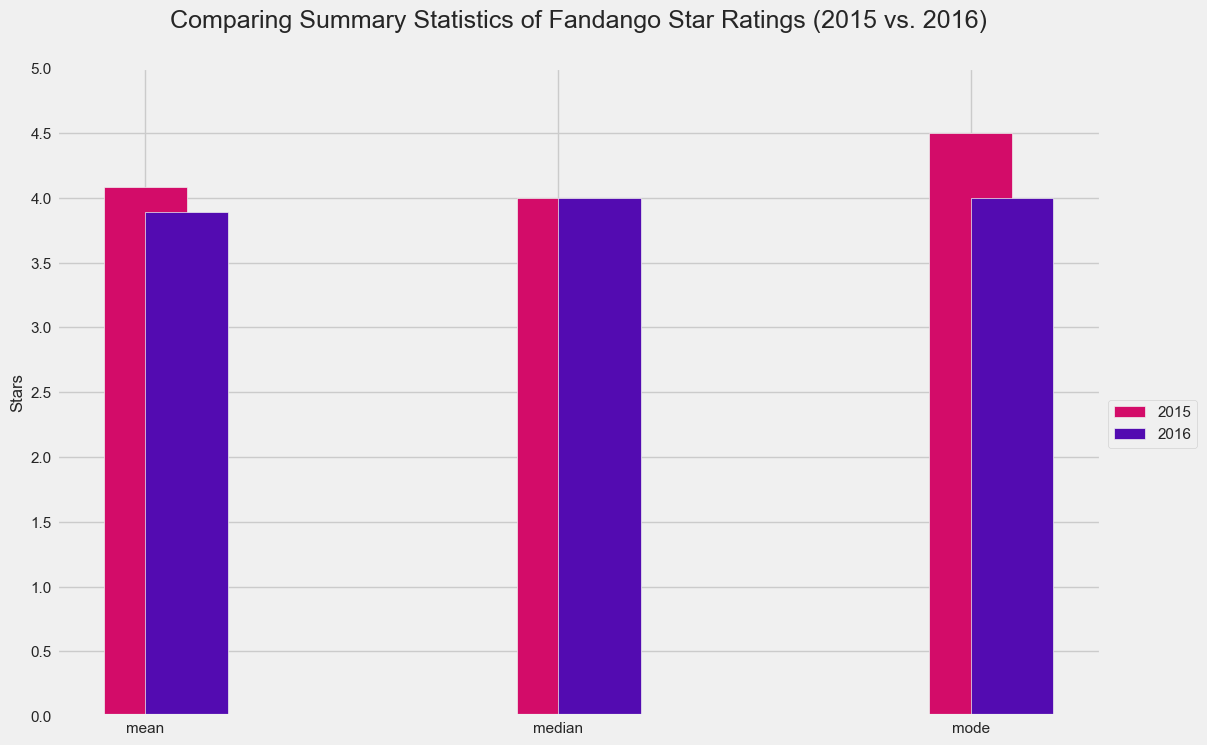

In [162]:
plt.style.use("fivethirtyeight")

plt.figure(figsize=(12, 8))

plt.subplot(1, 1, 1)

plt.bar(summary.index, summary["2015"], width=0.2, align="center", color="#D30C69FF", label="2015")
plt.bar(summary.index, summary["2016"], width=0.2, align="edge", color="#530BB1FF", label="2016")

plt.title("Comparing Summary Statistics of Fandango Star Ratings (2015 vs. 2016)", fontsize=18, y=1.05)
plt.legend(bbox_to_anchor=(1,0.5))

plt.ylim(0, 5)
plt.yticks(np.arange(0, 5.1, 0.5))
plt.ylabel("Stars", fontsize=12)

plt.show()

In [ ]:
((summary.loc["mean", "2016"] - summary.loc["mean", "2015"]) / summary.loc["mean", "2015"]) * 100 # calculate percentage change in the mean star rating between 2015 and 2016

np.float64(-4.842683568951993)

### Remarks

The mean rating dropped by roughly 0.2 points moving from 2015 to 2016. This corresponds to a **4.8% drop** in the mean star rating of popular movies. 

Although the median remains the same for both years, the modal star rating for popular movies drops from 4.5 stars in 2015 to 4.0 stars in 2016.

>This alongside the leftwards shift in the distribution from the KDE plot confirms that the average star rating of popular movies featured on Fandango in 2016 were lower than the Fandango star ratings of popular movies in 2015.

## Conclusion

>The analysis conducted herein illustrated there is indeed a noticeable difference between Fandango's ratings for popular movies over the 2015-2016 period. It was found that on average, popular movies released in 2016 had a lower star rating on Fandango than popular movies released in 2015. 

>We cannot claim with certainty what the cause for this difference is, but it is relatively likely considering the context of the situation that the difference is a result of the Fandango team amending their biased rating system post-exposé.